# Implemented Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
from graphviz import Digraph
from sklearn.metrics import mean_squared_error

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=4):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def visualize_tree(self, tree=None, dot=None, parent_name=None, yes_name=None, no_name=None):
        ''' Fonction pour visualiser l'arbre de décision avec graphviz '''
        if not dot:
            dot = Digraph()
        
        if not tree:
            tree = self.root
        
        if tree.value is not None:
            dot.node(name=str(id(tree)), label=str(tree.value))
            if parent_name:
                dot.edge(parent_name, str(id(tree)))
        else:
            dot.node(name=str(id(tree)), label=f"X{tree.feature_index} <= {tree.threshold:.2f}")
            if parent_name:
                dot.edge(parent_name, str(id(tree)))
            
            # Create left child node
            self.visualize_tree(tree.left, dot=dot, parent_name=str(id(tree)), yes_name=str(id(tree.left)), no_name=str(id(tree.right)))
            
            # Create right child node
            self.visualize_tree(tree.right, dot=dot, parent_name=str(id(tree)), yes_name=str(id(tree.left)), no_name=str(id(tree.right)))
        
        return dot
    
# Implémentation du Random Forest
class RandomForest():
    def __init__(self, n_estimators=10, min_samples_split=5, max_depth=5, max_features=None):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        
    def fit(self, X, Y):
        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            
            # Bootstrapping: échantillonnage avec remplacement
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample, Y_sample = X[indices, :], Y.iloc[indices]
            
            Y_sample = Y_sample.values.reshape(-1,1)

            # Entraîner l'arbre de décision
            tree.fit(X_sample, Y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        # Prédiction pour chaque arbre
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Moyenne des prédictions des arbres
        return np.mean(tree_preds, axis=0)

In [2]:
data = pd.read_csv('part2_final.csv')

In [3]:
target_column = "PSurfFall"
features = data.drop(columns=[target_column])
target = data[target_column]

# Conversion en tableaux numpy
X = features.values
Y = target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

# Mesurer le temps d'exécution pour l'entraînement
start_time = time.time()

# Entraîner le modèle Random Forest
rf = RandomForest(n_estimators=4, min_samples_split=5, max_depth=5)
rf.fit(X_train, Y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time:.4f} secondes")


Temps d'entraînement : 26.5282 secondes


In [4]:
start_time = time.time()

Y_pred = rf.predict(X_test) 

end_time = time.time()
prediction_time = end_time - start_time
print(f"Temps de prédiction : {prediction_time:.4f} secondes")

MSE = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Mean Squared Error (MSE): {MSE:.4f}")

Temps de prédiction : 0.0030 secondes
Mean Squared Error (MSE): 0.0554


In [7]:
print("Exemples de prédictions :")
print(f"Input: {X_test[0]}")
print(f"Predicted: {Y_pred[0]}")
print(f"Actual: {Y_test.iloc[0]}")

Exemples de prédictions :
Input: [25.25        4.25        0.09903108  0.20147059  0.19188596  0.09720177
  0.13919334  0.3907496   0.19642857  0.29645542  0.13105375  0.02981515
  0.0867052   0.04296875  0.12216449  0.72156276  0.62049486  0.5267347
  0.62288233  0.66358535]
Predicted: 0.34267690382780264
Actual: 0.345203152052878


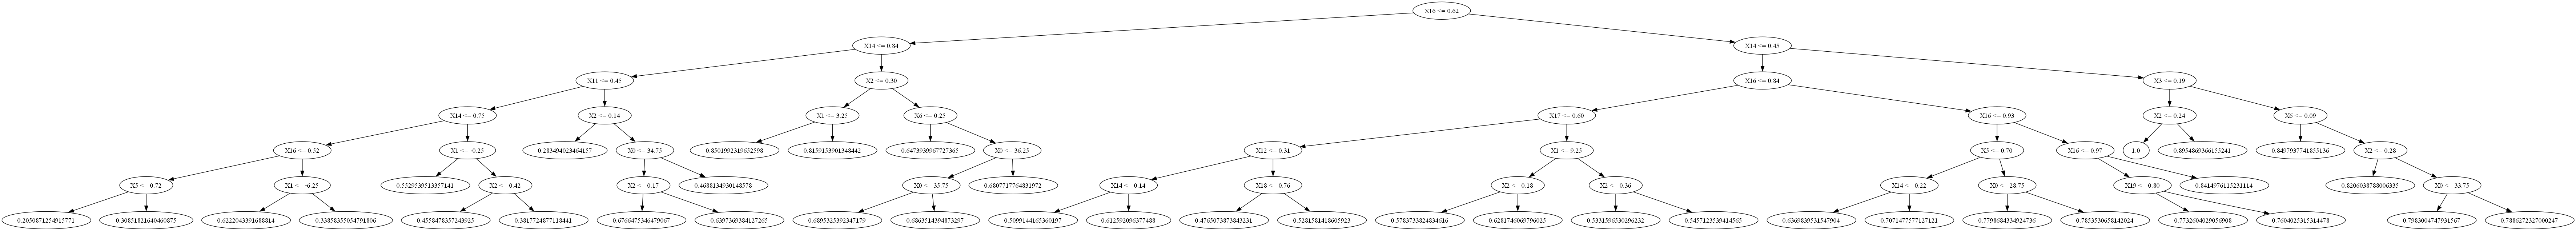

In [8]:
# Visualiser l'arbre de décision choisi (par exemple, l'arbre d'indice 0)
dot = rf.trees[0].visualize_tree()  # Prendre le premier arbre de la forêt
dot.render(f"random_forest_0", format="png", cleanup=True)  # Sauvegarder l'arbre au format PNG

from IPython.display import Image
Image("random_forest_0.png")

# Predefined Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

start_time = time.time()

# Création du modèle de régression par forêt aléatoire
clf = RandomForestRegressor(n_estimators=4, max_depth=5, random_state=41) 
clf.fit(X_train, Y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time:.4f} secondes")

Temps d'entraînement : 0.0281 secondes


In [13]:
start_time = time.time()

# Prédiction sur l'ensemble de test
Y_pred = clf.predict(X_test)

end_time = time.time()
prediction_time = end_time - start_time
print(f"Temps de prédiction : {prediction_time:.4f} secondes")

MSE = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Mean Squared Error (MSE): {MSE:.4f}")

Temps de prédiction : 0.0011 secondes
Mean Squared Error (MSE): 0.0529


In [14]:
print("Exemples de prédictions :")
print(f"Input: {X_test[0]}")
print(f"Predicted: {Y_pred[0]}")
print(f"Actual: {Y_test.iloc[0]}")

Exemples de prédictions :
Input: [25.25        4.25        0.09903108  0.20147059  0.19188596  0.09720177
  0.13919334  0.3907496   0.19642857  0.29645542  0.13105375  0.02981515
  0.0867052   0.04296875  0.12216449  0.72156276  0.62049486  0.5267347
  0.62288233  0.66358535]
Predicted: 0.33523856388379436
Actual: 0.345203152052878


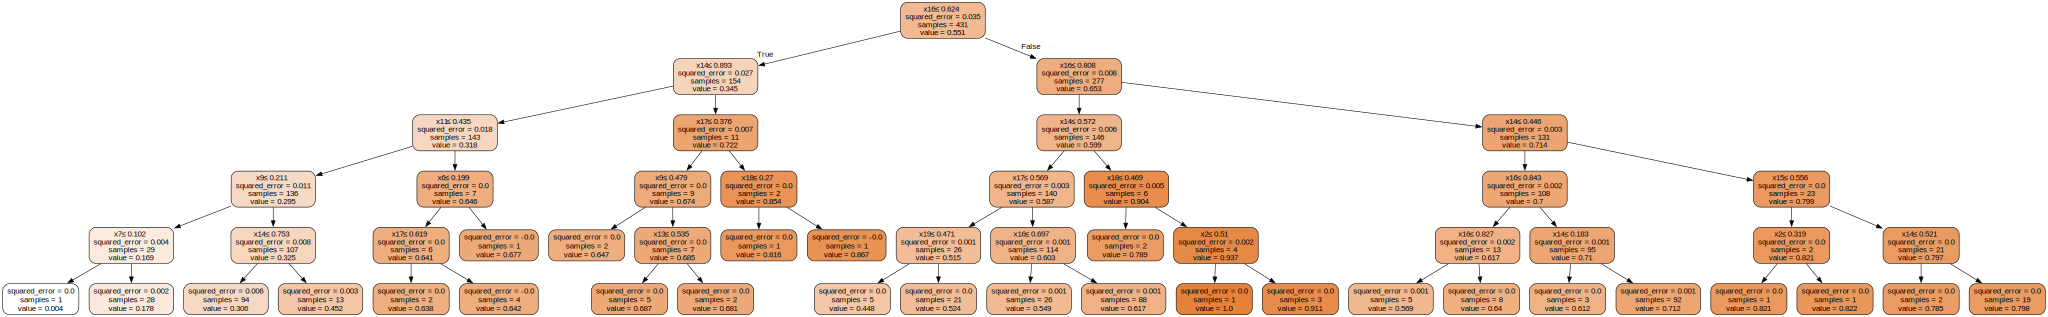

In [16]:
from sklearn.tree import export_graphviz
import graphviz

# Extraire le premier arbre de la forêt
first_tree = clf.estimators_[0]  # L'arbre ayant l'index 0

# Exporter l'arbre au format Graphviz
dot_data = export_graphviz(
    first_tree, 
    out_file=None,  # Pas besoin d'écrire dans un fichier
    filled=True, 
    rounded=True, 
    special_characters=True
)

# Créer un objet Graphviz et l'afficher
graph = graphviz.Source(dot_data)
graph  # Cela affichera l'arbre dans Jupyter